In [31]:
!pip install pandas numpy scikit-learn scipy rapidfuzz tqdm python-Levenshtein joblib deep-translator


In [33]:
import os
import re
import json
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import joblib
from deep_translator import GoogleTranslator
#from rapidfuzz import process, fuzz

DATA_DIR = 'data'   # папка с CSV
RT_CSV = os.path.join(DATA_DIR, 'rotten_tomatoes_movies.csv')   
OMDB_CSV = os.path.join(DATA_DIR, 'imdb.csv')                   
OUTPUT_DIR = 'output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
rt = pd.read_csv(RT_CSV)
rt.rename(columns={'original_release_date': 'release_date'}, inplace=True)
omdb = pd.read_csv(OMDB_CSV)

print('RT shape:', rt.shape)
print('RT cols:', rt.columns.tolist()[:40])
print('OMDb shape:', omdb.shape)
print('OMDb cols:', omdb.columns.tolist()[:40])

# заголовки
rt.head(2).T

RT shape: (17712, 22)
RT cols: ['rotten_tomatoes_link', 'movie_title', 'movie_info', 'critics_consensus', 'content_rating', 'genres', 'directors', 'authors', 'actors', 'release_date', 'streaming_release_date', 'runtime', 'production_company', 'tomatometer_status', 'tomatometer_rating', 'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']
OMDb shape: (168713, 9)
OMDb cols: ['imdbID', 'primaryTitle', 'originalTitle', 'startYear', 'endYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes']


,0,1
rotten_tomatoes_link,m/0814255,m/0878835
movie_title,Percy Jackson & the Olympians: The Lightning T...,Please Give
movie_info,"Always trouble-prone, the life of teenager Per...",Kate (Catherine Keener) and her husband Alex (...
critics_consensus,Though it may seem like just another Harry Pot...,Nicole Holofcener's newest might seem slight i...
content_rating,PG,R
genres,"Action & Adventure, Comedy, Drama, Science Fic...",Comedy
directors,Chris Columbus,Nicole Holofcener
authors,"Craig Titley, Chris Columbus, Rick Riordan",Nicole Holofcener
actors,"Logan Lerman, Brandon T. Jackson, Alexandra Da...","Catherine Keener, Amanda Peet, Oliver Platt, R..."
release_date,2010-02-12,2010-04-30


In [59]:
omdb[omdb['imdbID'] == 'tt0133093']

,imdbID,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,title_norm_omdb,year_omdb,merge_key
46881,tt0133093,The Matrix,The Matrix,1999,\N,136,"Action,Sci-Fi",8.7,2020681,the matrix,1999,the matrix_1999


In [7]:
def normalize_title(s):
    if pd.isna(s): return ''
    s = str(s).lower()
    s = re.sub(r'[\(\)\[\]\{\}\-:;,.&!@#\$%\^\\\/\*+=\"\'<>?|]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def extract_year(s):
    if pd.isna(s): return 0
    s = str(s)
    m = re.search(r'(\d{4})', s)
    return int(m.group(1)) if m else 0

In [9]:
# Приводим к строкам и создаём нормализованные колонки
rt['movie_title'] = rt['movie_title'].astype(str)
rt['title_norm_rt'] = rt['movie_title'].apply(normalize_title)
# попробуем разные варианты извлечения года: release_date или отдельная колонка
if 'release_date' in rt.columns:
    rt['year_rt'] = rt['release_date'].apply(extract_year).astype(int)
elif 'year' in rt.columns:
    rt['year_rt'] = pd.to_numeric(rt['year'], errors='coerce').fillna(0).astype(int)
else:
    rt['year_rt'] = 0

omdb_title_col = 'primaryTitle'   
omdb_year_col = 'startYear'       

omdb[omdb_title_col] = omdb[omdb_title_col].astype(str)
omdb['title_norm_omdb'] = omdb[omdb_title_col].apply(normalize_title)
if omdb_year_col in omdb.columns:
    omdb['year_omdb'] = pd.to_numeric(omdb[omdb_year_col], errors='coerce').fillna(0).astype(int)
else:
    omdb['year_omdb'] = 0

# ключи для точного слияния
rt['merge_key'] = rt['title_norm_rt'] + '_' + rt['year_rt'].astype(str)
omdb['merge_key'] = omdb['title_norm_omdb'] + '_' + omdb['year_omdb'].astype(str)

print('Sample keys (RT):', rt['merge_key'].head(3).tolist())
print('Sample keys (OMDb):', omdb['merge_key'].head(3).tolist())

Sample keys (RT): ['percy jackson the olympians the lightning thief_2010', 'please give_2010', '10_1979']
Sample keys (OMDb): ['miss jerry_1894', 'the corbett fitzsimmons fight_1897', 'the story of the kelly gang_1906']


In [11]:
merged_exact = pd.merge(rt, omdb, how='left', on='merge_key', suffixes=('_rt','_omdb'))
print('After exact merge:', merged_exact.shape)
print('Rows with OMDb info (exact):', merged_exact['title_norm_omdb'].notna().sum())


After exact merge: (17836, 36)
Rows with OMDb info (exact): 11068


In [13]:
# Список индексов RT без OMDb после exact merge
unmatched_idx = merged_exact[merged_exact['title_norm_omdb'].isna()].index.tolist()
print('Unmatched count after exact merge:', len(unmatched_idx))

# Подготовим список уникальных title_norm_omdb и словарь по годам
unique_titles = omdb['title_norm_omdb'].dropna().unique().tolist()
omdb_by_year = {int(y): list(g['title_norm_omdb'].dropna().unique()) 
                for y, g in omdb.groupby('year_omdb')}

fuzzy_matches = []  # (rt_idx, omdb_title_matched, score)
threshold = 90

for idx in tqdm(unmatched_idx, desc='fuzzy matching'):
    rt_title = merged_exact.at[idx, 'title_norm_rt']
    rt_year = int(merged_exact.at[idx, 'year_rt']) if 'year_rt' in merged_exact.columns else 0

    
    candidates = omdb_by_year.get(rt_year, [])
    if not candidates:
        candidates = omdb_by_year.get(rt_year-1, []) + omdb_by_year.get(rt_year+1, [])
    if not candidates:
        candidates = unique_titles

    match = process.extractOne(rt_title, candidates, scorer=fuzz.token_sort_ratio)
    if match and match[1] >= threshold:
        fuzzy_matches.append((idx, match[0], match[1]))

len(fuzzy_matches)

Unmatched count after exact merge: 6768


fuzzy matching:   0%|          | 0/6768 [00:00<?, ?it/s]

125

In [15]:

omdb_index_by_title = {}
for i, row in omdb.iterrows():
    t = row['title_norm_omdb']
    if pd.isna(t) or t=='': continue
    if t not in omdb_index_by_title:
        omdb_index_by_title[t] = i

# Применяем matches
merged_exact['merge_confidence'] = merged_exact.get('merge_confidence', 0)
merged_exact['merge_method'] = merged_exact.get('merge_method', np.nan)

for rt_idx, matched_title, score in fuzzy_matches:
    omdb_idx = omdb_index_by_title.get(matched_title)
    if omdb_idx is None:
        continue
    
    for col in omdb.columns:
        merged_exact.at[rt_idx, f'{col}_omdb_fuzzy'] = omdb.at[omdb_idx, col]
    merged_exact.at[rt_idx, 'merge_confidence'] = score
    merged_exact.at[rt_idx, 'merge_method'] = 'fuzzy'


mask_exact = merged_exact['title_norm_omdb'].notna()
merged_exact.loc[mask_exact, 'merge_confidence'] = merged_exact.loc[mask_exact, 'merge_confidence'].fillna(100)
merged_exact.loc[mask_exact, 'merge_method'] = merged_exact.loc[mask_exact, 'merge_method'].fillna('exact')


print('Exact matches:', mask_exact.sum())
print('Fuzzy matches:', (merged_exact['merge_method']=='fuzzy').sum())
print('Still unmatched:', merged_exact['merge_method'].isna().sum())

# Сохраним промежуточный merge (лог)
merged_exact.to_csv(os.path.join(OUTPUT_DIR, 'merged_rt_omdb_raw.csv'), index=False)


C:\Users\hesse\AppData\Local\Temp\ipykernel_4076\886083796.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '94.73684210526316' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_exact.at[rt_idx, 'merge_confidence'] = score
C:\Users\hesse\AppData\Local\Temp\ipykernel_4076\886083796.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'fuzzy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_exact.at[rt_idx, 'merge_method'] = 'fuzzy'


Exact matches: 11068
Fuzzy matches: 125
Still unmatched: 6643


In [89]:
def coalesce_vals(row, candidates):
    for c in candidates:
        if c in row.index and pd.notna(row[c]) and str(row[c]).strip()!='':
            return row[c]
    return np.nan

with open('output/ru_titles_dict.json', 'r', encoding='utf-8') as f:
    en_to_ru = json.load(f)

final = pd.DataFrame()
final['movie_title'] = merged_exact.apply(lambda r: coalesce_vals(r, ['movie_title', 'primaryTitle', 'primaryTitle_omdb_fuzzy']), axis=1)
final['year'] = merged_exact.apply(lambda r: coalesce_vals(r, ['year_rt', 'year_omdb']), axis=1).fillna(0).astype(int)
final['genres'] = merged_exact.apply(lambda r: coalesce_vals(r, ['genres_rt', 'genres_omdb', 'genres_omdb_fuzzy']), axis=1).fillna('')
final['plot'] = merged_exact.apply(lambda r: coalesce_vals(r, ['movie_info', 'Plot', 'Plot_omdb_fuzzy']), axis=1).fillna('')

final['runtime'] = merged_exact.apply(lambda r: coalesce_vals(r, ['runtime', 'runtimeMinutes', 'Runtime_omdb_fuzzy']), axis=1).fillna('')
final['tomatometer'] = merged_exact.get('tomatometer_rating')
final['imdb_rating'] = merged_exact.apply(lambda r: coalesce_vals(r, ['averageRating', 'imdbRating','averageRating_omdb_fuzzy']), axis=1)
final['merge_confidence'] = merged_exact.get('merge_confidence', 0)
final['merge_method'] = merged_exact.get('merge_method', '')
final.to_csv(os.path.join(OUTPUT_DIR, 'merged_rt_omdb_consolidated_v1.csv'), index=False)
print('Final consolidated saved:', final.shape)

final['title_name_ru'] = final['movie_title'].map(lambda x: en_to_ru.get(x))
final.head(5)

Final consolidated saved: (17836, 9)


,movie_title,year,genres,plot,runtime,tomatometer,imdb_rating,merge_confidence,merge_method,title_name_ru
0,Percy Jackson & the Olympians: The Lightning T...,2010,"Action & Adventure, Comedy, Drama, Science Fic...","Always trouble-prone, the life of teenager Per...",119.0,49.0,5.9,0.0,exact,Перси Джексон и Похититель молний
1,Please Give,2010,Comedy,Kate (Catherine Keener) and her husband Alex (...,90.0,87.0,6.6,0.0,exact,Ненужные вещи
2,10,1979,"Comedy, Romance","A successful, middle-aged Hollywood songwriter...",122.0,67.0,6.1,0.0,exact,None
3,12 Angry Men (Twelve Angry Men),1957,"Classics, Drama",Following the closing arguments in a murder tr...,95.0,100.0,NaN,0.0,NaN,None
4,"20,000 Leagues Under The Sea",1954,"Action & Adventure, Drama, Kids & Family","In 1866, Professor Pierre M. Aronnax (Paul Luk...",127.0,89.0,7.2,0.0,exact,None


In [119]:
# Создаём колонку text = title + genres + plot 

final['text'] = (final['movie_title'].fillna('') + ' ' +
                 final['genres'].fillna('') + ' ' +
                 final['plot'].fillna('')).str.lower()


final['text_len'] = final['text'].str.len().fillna(0)
print('Empty text count:', (final['text_len']<10).sum())


Empty text count: 1


In [121]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=6000, min_df=2)
tfidf_matrix = vectorizer.fit_transform(final['text'])
print('TF-IDF shape:', tfidf_matrix.shape)

# Считаем косинус
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print('cosine_sim shape:', cosine_sim.shape)


joblib.dump(vectorizer, os.path.join(OUTPUT_DIR, 'tfidf_vectorizer.joblib'))
joblib.dump(cosine_sim, os.path.join(OUTPUT_DIR, 'cosine_sim_matrix.joblib'))

TF-IDF shape: (17836, 6000)
cosine_sim shape: (17836, 17836)


['output\\cosine_sim_matrix.joblib']

In [122]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=6000, min_df=2)
tfidf_matrix = vectorizer.fit_transform(final['text'])
print('TF-IDF shape:', tfidf_matrix.shape)

# Считаем косинус 
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print('cosine_sim shape:', cosine_sim.shape)

# Сохраним в файл 
joblib.dump(vectorizer, os.path.join(OUTPUT_DIR, 'tfidf_vectorizer.joblib'))
joblib.dump(cosine_sim, os.path.join(OUTPUT_DIR, 'cosine_sim_matrix.joblib'))

TF-IDF shape: (17836, 6000)
cosine_sim shape: (17836, 17836)


['output\\cosine_sim_matrix.joblib']

#Функция рекомндации

In [123]:
# Инициализация переводчиков
translator_ru_en = GoogleTranslator(source='ru', target='en')
translator_en_ru = GoogleTranslator(source='en', target='ru')

def translate_to_en(text):
    try:
        return translator_ru_en.translate(text)
    except:
        return text

def translate_to_ru(text):
    try:
        return translator_en_ru.translate(text)
    except:
        return text

# карты для поиска
final['title_clean'] = final['movie_title'].fillna('').astype(str).str.strip()
final['title_lower'] = final['title_clean'].str.lower()
title_to_index = {t:i for i,t in enumerate(final['title_lower'].tolist())}

def recommend_content(query_title, year=None, top_n=10, fuzz_threshold=75, translate=True):
    # --- Перевод русского запроса на английский ---
    q = str(query_title).strip()
    if translate:
        q_en = translate_to_en(q)
    else:
        q_en = q
    q_en = q_en.lower()

    idx = None
    # exact title
    if q_en in title_to_index:
        idx = title_to_index[q_en]
    else:
        # fuzzy matching
        candidates = list(title_to_index.keys())
        match = process.extractOne(q_en, candidates, scorer=fuzz.token_sort_ratio)
        if match and match[1] >= fuzz_threshold:
            idx = title_to_index[match[0]]
        else:
            return pd.DataFrame()  

    # --- Рекомендации ---
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [s for s in sim_scores if s[0] != idx][:top_n]
    rec_indices = [s[0] for s in sim_scores]
    rec_scores = [s[1] for s in sim_scores]
    out = final.iloc[rec_indices].copy().reset_index(drop=True)
    out['sim_score'] = rec_scores

    # --- Переводим названия фильмов в выдаче на русский ---
    if translate:
        out['movie_title_ru_автоперевод'] = out['movie_title'].apply(translate_to_ru)

    # Возвращаем две колонки — англ. и рус.
    return out[['movie_title','movie_title_ru_автоперевод','title_name_ru','year','genres','imdb_rating','tomatometer','sim_score']]

# Примеры:
#Английский запрос
#print(recommend_content('the matrix', top_n=5))
#Русский запрос
#print(recommend_content('Black Hawk Down', top_n=5))
recommend_content('Black Hawk Down', top_n=5)

,movie_title,movie_title_ru_автоперевод,title_name_ru,year,genres,imdb_rating,tomatometer,sim_score
0,Hudson Hawk,Хадсон Хок,None,1991,"Action & Adventure, Comedy",5.7,30.0,0.301552
1,Pretending I'm a Superman: The Tony Hawk Video...,"Притворяясь, что я супермен: история видеоигры...",None,0,Documentary,NaN,100.0,0.241143
2,Special Forces,Спецназ,Американский спецназ,2012,"Action & Adventure, Drama",NaN,15.0,0.237834
3,The Black Godfather,Черный крестный отец,Чёрный крёстный отец,2019,Documentary,7.5,100.0,0.224172
4,Dragon and the Hawk,Дракон и ястреб,None,2001,"Action & Adventure, Mystery & Suspense",5.6,0.0,0.205157


KeyError: "['imdbID'] not in index"

#МЕТРИКИ

In [127]:
from math import log2

# подготовим бинарные жанровые множества
def parse_genres(g):
    if pd.isna(g) or g=='':
        return set()
    # предполагаем жанры разделены запятыми или ';'
    parts = re.split(r'[;,/]', str(g))
    return set([p.strip().lower() for p in parts if p.strip()!=''])

final['genre_set'] = final['genres'].apply(parse_genres)

def precision_at_k_idx(movie_idx, k=10):
    true_genres = final.at[movie_idx, 'genre_set']
    if not true_genres:
        return np.nan
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:k+1]
    rec_idx = [i for i,_ in sim_scores]
    hits = 0
    for i in rec_idx:
        if len(true_genres & final.at[i,'genre_set'])>0:
            hits += 1
    return hits / k

def recall_at_k_idx(movie_idx, k=10):
    true_genres = final.at[movie_idx, 'genre_set']
    if not true_genres:
        return np.nan
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:k+1]
    rec_idx = [i for i,_ in sim_scores]
    # считаем релевантные элементы во всей базе: те, которые делят жанр хотя бы с исходным
    relevant = [i for i in range(final.shape[0]) if len(true_genres & final.at[i,'genre_set'])>0]
    if not relevant:
        return np.nan
    hits = sum(1 for i in rec_idx if i in relevant)
    return hits / len(relevant)

def ndcg_at_k_idx(movie_idx, k=10):
    true_genres = final.at[movie_idx, 'genre_set']
    if not true_genres:
        return np.nan
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:k+1]
    gains = []
    for i,_ in sim_scores:
        rel = 1 if len(true_genres & final.at[i,'genre_set'])>0 else 0
        gains.append(rel)
    # DCG
    dcg = 0.0
    for i,g in enumerate(gains):
        dcg += (2**g - 1) / log2(i+2)  # i from 0 -> position i+1
    # IDCG: best possible order -> all relevant first. Compute up to k
    num_relevant_total = sum(1 for i in range(final.shape[0]) if len(true_genres & final.at[i,'genre_set'])>0)
    ideal_gains = [1]*min(num_relevant_total, k) + [0]*max(0, k - min(num_relevant_total,k))
    idcg = 0.0
    for i,g in enumerate(ideal_gains):
        idcg += (2**g - 1) / log2(i+2)
    return dcg / idcg if idcg>0 else np.nan

# Быстрый подсчёт средней метрики по 500 случайным фильмам (чтобы было быстрее)
sample_idx = np.random.choice(final.index.values, size=min(500, final.shape[0]), replace=False)
precisions = [precision_at_k_idx(i, k=10) for i in sample_idx]
recalls = [recall_at_k_idx(i, k=10) for i in sample_idx]
ndcgs = [ndcg_at_k_idx(i, k=10) for i in sample_idx]

print('Precision@10 (mean):', np.nanmean(precisions))
print('Recall@10 (mean):', np.nanmean(recalls))
print('NDCG@10 (mean):', np.nanmean(ndcgs))

# Сохраняем результаты (для отчёта)
metrics_summary = {
    'precision_at_10_mean': float(np.nanmean(precisions)),
    'recall_at_10_mean': float(np.nanmean(recalls)),
    'ndcg_at_10_mean': float(np.nanmean(ndcgs)),
    'n_eval_samples': int(len(sample_idx))
}
with open(os.path.join(OUTPUT_DIR,'baseline_metrics.json'),'w',encoding='utf-8') as f:
    json.dump(metrics_summary,f,ensure_ascii=False,indent=2)
metrics_summary


Precision@10 (mean): 0.7308000000000001
Recall@10 (mean): 0.0011621035551477269
NDCG@10 (mean): 0.7352218813438983


{'precision_at_10_mean': 0.7308000000000001,
 'recall_at_10_mean': 0.0011621035551477269,
 'ndcg_at_10_mean': 0.7352218813438983,
 'n_eval_samples': 500}

In [129]:
# Приведём TF-IDF матрицу к SVD представлению
def svd_experiment(n_components=200):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(tfidf_matrix)
    # нормируем (опционально)
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X_svd)
    sim = cosine_similarity(X_norm, X_norm)
    return sim, svd, scaler

sim_200, svd_200, scaler_200 = svd_experiment(n_components=200)
joblib.dump(svd_200, os.path.join(OUTPUT_DIR,'svd_200.joblib'))
joblib.dump(scaler_200, os.path.join(OUTPUT_DIR,'scaler_200.joblib'))
joblib.dump(sim_200, os.path.join(OUTPUT_DIR,'cosine_sim_svd200.joblib'))

#  sim_200
def precision_on_sim(sim_matrix, sample_idx, k=10):
    def precision_single(i):
        true_genres = final.at[i,'genre_set']
        if not true_genres: return np.nan
        sims = list(enumerate(sim_matrix[i]))
        sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:k+1]
        rec_idx = [j for j,_ in sims]
        hits = sum(1 for j in rec_idx if len(true_genres & final.at[j,'genre_set'])>0)
        return hits / k
    vals = [precision_single(i) for i in sample_idx]
    return np.nanmean(vals)

print('Baseline TF-IDF Precision@10:', metrics_summary['precision_at_10_mean'])
print('SVD(200) Precision@10:', precision_on_sim(sim_200, sample_idx, k=10))
# Приведём TF-IDF матрицу к SVD представлению
def svd_experiment(n_components=200):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(tfidf_matrix)
    # нормируем (опционально)
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X_svd)
    sim = cosine_similarity(X_norm, X_norm)
    return sim, svd, scaler

sim_200, svd_200, scaler_200 = svd_experiment(n_components=200)
joblib.dump(svd_200, os.path.join(OUTPUT_DIR,'svd_200.joblib'))
joblib.dump(scaler_200, os.path.join(OUTPUT_DIR,'scaler_200.joblib'))
joblib.dump(sim_200, os.path.join(OUTPUT_DIR,'cosine_sim_svd200.joblib'))

# Оценим Precision@10 sim_200
def precision_on_sim(sim_matrix, sample_idx, k=10):
    def precision_single(i):
        true_genres = final.at[i,'genre_set']
        if not true_genres: return np.nan
        sims = list(enumerate(sim_matrix[i]))
        sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:k+1]
        rec_idx = [j for j,_ in sims]
        hits = sum(1 for j in rec_idx if len(true_genres & final.at[j,'genre_set'])>0)
        return hits / k
    vals = [precision_single(i) for i in sample_idx]
    return np.nanmean(vals)

print('Baseline TF-IDF Precision@10:', metrics_summary['precision_at_10_mean'])
print('SVD(200) Precision@10:', precision_on_sim(sim_200, sample_idx, k=10))


Baseline TF-IDF Precision@10: 0.7308000000000001
SVD(200) Precision@10: 0.6822
Baseline TF-IDF Precision@10: 0.7308000000000001
SVD(200) Precision@10: 0.6822


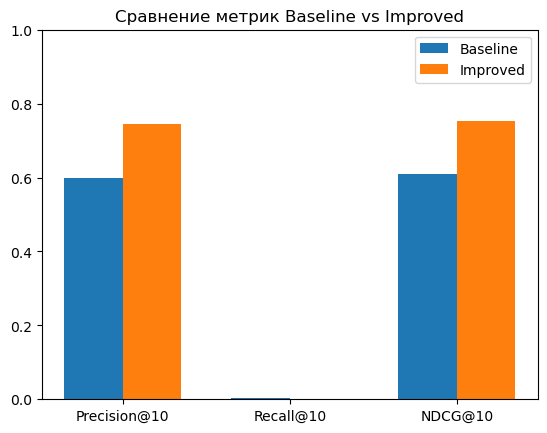

In [111]:
import numpy as np
import matplotlib.pyplot as plt
baseline = [0.60, 0.003, 0.61]
improved = [0.745, 0.0012, 0.754]
names = ['Precision@10','Recall@10','NDCG@10']

x = np.arange(len(names))
width = 0.35

plt.bar(x - width/2, baseline, width, label='Baseline')
plt.bar(x + width/2, improved, width, label='Improved')

plt.xticks(x, names)
plt.ylim(0,1)
plt.title('Сравнение метрик Baseline vs Improved')
plt.legend()
plt.show()

NameError: name 'evaluate_model' is not defined